In [1]:
# import data
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

# based on the plot, it seems like normal distribution

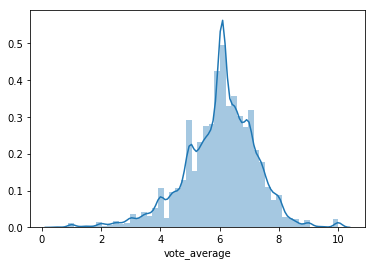

In [65]:
df = pd.read_csv('/Users/sunyu/Desktop/Ds5230/ds_project/data/movies_metadata.csv')
df['vote_average'] = df['vote_average'].replace(0, np.nan)
sns.distplot(df['vote_average'].fillna(df['vote_average'].median()))

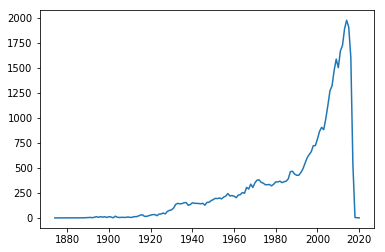

In [66]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
year_gen = pd.DataFrame(df['year'].value_counts()).reset_index()
year_gen.columns = ['year', 'counts']
year_gen.drop([87,135,],inplace=True)
year_gen['year']=year_gen['year'].astype('int')
year_gen = year_gen.sort_values(by=['year'])# sort year 
plt.plot(year_gen.year,year_gen.counts)

## love day man gril are in most movie title

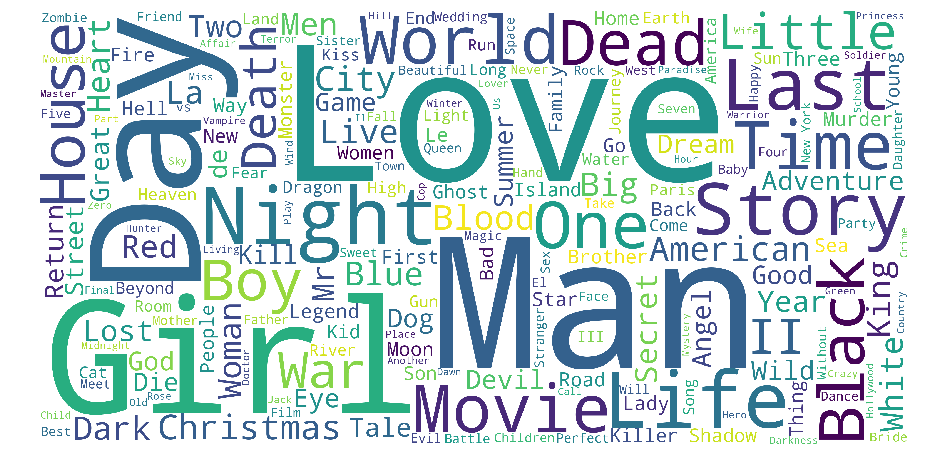

In [47]:
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')
title_corpus = ' '.join(df['title'])
overview_corpus = ' '.join(df['overview'])
from wordcloud import WordCloud, STOPWORDS
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

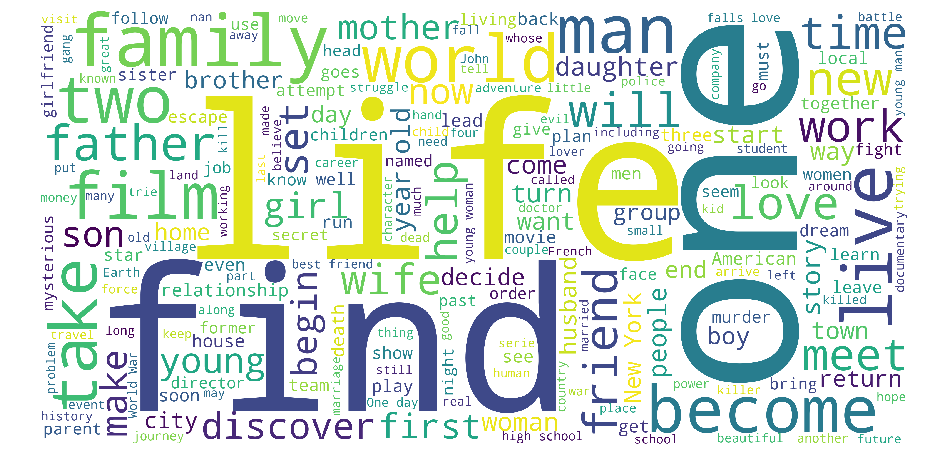

In [48]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

<BarContainer object of 20 artists>

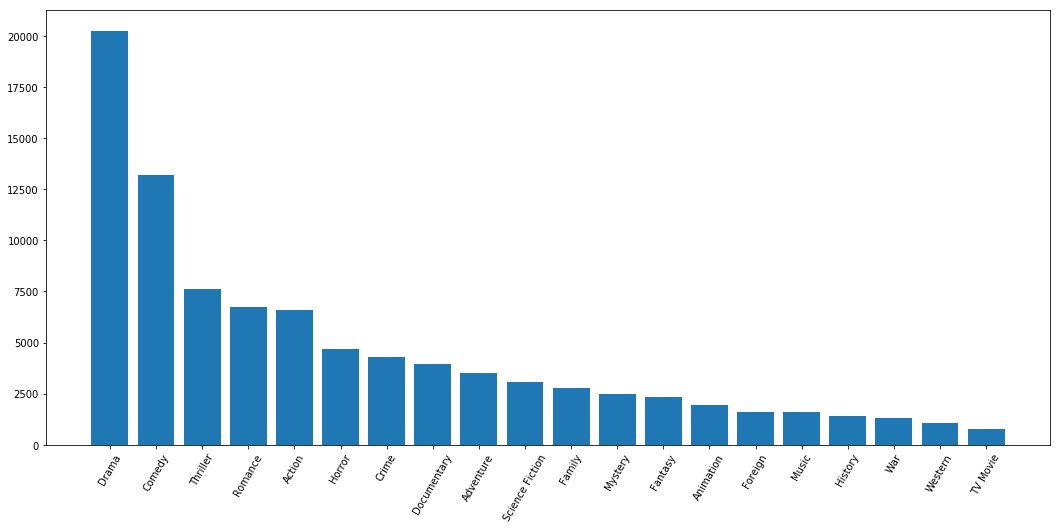

In [67]:
genres = df.genres.map(lambda t: eval(t))
g_list = list(map(lambda t: list(map(lambda k: k['name'],t)), genres))
g_count = {}
for i in g_list:
    for j in i:
        g_count[j] = g_count.get(j,0)
        g_count[j] += 1
filter_count = list(filter(lambda k: k[1] > 10, g_count.items()))
filter_count = {i[0]:i[1] for i in sorted(filter_count, key = lambda k: k[1], reverse = True)}
plt.figure(figsize=(18,8))
plt.tick_params(axis='x',labelrotation=60)
plt.bar(filter_count.keys(),filter_count.values())

In [2]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words
# import data
df = pd.read_csv('/Users/sunyu/Desktop/Ds5230/ds_project/data/movies_metadata.csv')
links_small = pd.read_csv('/Users/sunyu/Desktop/Ds5230/ds_project/data/links_small.csv')
credits = pd.read_csv('/Users/sunyu/Desktop/Ds5230/ds_project/data/credits.csv')
keywords = pd.read_csv('/Users/sunyu/Desktop/Ds5230/ds_project/data/keywords.csv')
# extract movie genre and year
df['genres'] = df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])#将电影类型解析出来
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
df = df.drop([19730, 29503, 35587])
df['id'] = df['id'].astype('int')


#links_small = pd.read_csv('/Users/sunyu/Desktop/Ds5230/ds_project/data/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
#df = df.drop([19730, 29503, 35587])
#df['id'] = df['id'].astype('int')

keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
df['id'] = df['id'].astype('int')

#基于电影详细信息的推荐
#credits = pd.read_csv('/Users/sunyu/Desktop/Ds5230/ds_project/data/credits.csv')
#keywords = pd.read_csv('/Users/sunyu/Desktop/Ds5230/ds_project/data/keywords.csv')
df = df.merge(credits, on='id')
df = df.merge(keywords, on='id')

smd = df[df['id'].isin(links_small)]
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

#def get_director(x):
   # for i in x:
        #if i['job'] == 'Director':
            #return i['name']
    # np.nan

smd['director'] = smd['crew'].apply(get_director)   #工作人员中仅仅选取出导演
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)  #选出3个主演
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

#将演员、导演的名字进行处理，名字连在一减少词的个数
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s = s.value_counts()

stemmer = SnowballStemmer('english')  #英语的词干提取

#def filter_keywords(x):
    #words = []
    #for i in x:
       # if i in s:
            #words.append(i)
   # return words

#类似于导演和演员名字，对关键词进行处理
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])   #基于词向量统计的矩阵
cosine_sim = cosine_similarity(count_matrix, count_matrix)
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')

s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = df.drop('genres', axis=1).join(s)
gen_md.head(3).transpose()

def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)





# df['col1']=df['col1'].map(lambda t: t.lower())

In [111]:
#'comedy'.lower() in list(filter_count.keys())
#indices 
lower_title = list(smd['title'])   
for i in range(len(lower_title)):
    lower_title[i] = lower_title[i].lower()
print(lower_title)

#smd['title'].apply(lambda x: [str.lower() for i in list(x)])
    
#df['genres'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
#print('Drama'.lower())

['toy story', 'jumanji', 'grumpier old men', 'waiting to exhale', 'father of the bride part ii', 'heat', 'sabrina', 'tom and huck', 'sudden death', 'goldeneye', 'the american president', 'dracula: dead and loving it', 'balto', 'nixon', 'cutthroat island', 'casino', 'sense and sensibility', 'four rooms', 'ace ventura: when nature calls', 'money train', 'get shorty', 'copycat', 'assassins', 'powder', 'leaving las vegas', 'othello', 'now and then', 'persuasion', 'the city of lost children', 'shanghai triad', 'dangerous minds', 'twelve monkeys', 'babe', 'carrington', 'dead man walking', 'across the sea of time', 'it takes two', 'clueless', 'cry, the beloved country', 'richard iii', 'dead presidents', 'restoration', 'mortal kombat', 'to die for', 'how to make an american quilt', 'se7en', 'pocahontas', 'when night is falling', 'the usual suspects', 'mighty aphrodite', 'lamerica', 'the big green', 'georgia', 'home for the holidays', 'the postman', 'the confessional', 'the indian in the cupboa

## Using movie description, taglines, keywords, cast, director and genres, Add Popularity and Ratings

In [5]:
def content_based(title):
    def improved_recommendations(title):
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:26]
        movie_indices = [i[0] for i in sim_scores]

        movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
        vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
        vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
        global C
        global m
        C = vote_averages.mean()
        m = vote_counts.quantile(0.60)
        qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
        qualified['vote_count'] = qualified['vote_count'].astype('int')
        qualified['vote_average'] = qualified['vote_average'].astype('int')
        qualified['wr'] = qualified.apply(weighted_rating, axis=1)
        qualified = qualified.sort_values('wr', ascending=False).head(10)
        return qualified
    def get_Genre(title):
        df = gen_md[gen_md['genre'] == title]
        vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
        vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
        global C
        global m
        C = vote_averages.mean()
        m = vote_counts.quantile(0.9)
        qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())]
        qualified['vote_count'] = qualified['vote_count'].astype('int')
        qualified['vote_average'] = qualified['vote_average'].astype('int')
        qualified['wr'] = qualified.apply(weighted_rating, axis=1)
        #qualified_avg = qualified.sort_values('vote_average', ascending=False)[['title', 'year', 'vote_count', 'vote_average', 'popularity','genres','wr']]
        qualified_wr = qualified.sort_values('wr', ascending=False)[['title', 'year', 'vote_count', 'vote_average', 'popularity','genre','wr']].head(10)
        return qualified_wr
    a = input('choose genres or movie_title, type t as movie_title, type g as genres, type e as exit')
    if a == 't':
        return improved_recommendations(title)
    elif a == 'g':
        return get_Genre(title)
    else:
        print('thx')
   

In [8]:
content_based('The Godfather')

choose genres or movie_title, type t as movie_title, type g as genres, type e as exitt


,title,vote_count,vote_average,year,wr
994,The Godfather: Part II,3418,8,1974,7.858316
986,GoodFellas,3211,8,1990,7.849867
981,Apocalypse Now,2112,8,1979,7.780325
1602,The Godfather: Part III,1589,7,1990,6.859105
1100,Dracula,1087,7,1992,6.806619
2998,The Conversation,377,7,1974,6.591280
2808,Midnight Express,309,7,1978,6.542486
1691,The Outsiders,293,6,1983,6.000000
7464,The Bad Lieutenant: Port of Call - New Orleans,331,6,2009,6.000000
642,Jack,340,5,1996,5.433899


In [61]:
x='Toy'
y = list(filter(lambda t: x in t.split(),list(smd['title'])))
print(y)

['Toy Story', 'Toy Story 2', 'The Toy', 'Toy Soldiers', 'Toy Story 3', 'Toy Story of Terror!']


In [145]:
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = df.drop('genres', axis=1).join(s)
gen_md.head(3).transpose()

,0,0,0
adult,False,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...","{'id': 10194, 'name': 'Toy Story Collection', ...","{'id': 10194, 'name': 'Toy Story Collection', ..."
budget,30000000,30000000,30000000
homepage,http://toystory.disney.com/toy-story,http://toystory.disney.com/toy-story,http://toystory.disney.com/toy-story
id,862,862,862
imdb_id,tt0114709,tt0114709,tt0114709
original_language,en,en,en
original_title,Toy Story,Toy Story,Toy Story
overview,"Led by Woody, Andy's toys live happily in his ...","Led by Woody, Andy's toys live happily in his ...","Led by Woody, Andy's toys live happily in his ..."
popularity,21.9469,21.9469,21.9469


In [183]:
# 贝叶斯算法
# 其中，WR为加权得分，R为该电影的用户投票平均得分，V为该电影的投票人数，m为最低评分个数，C为所有电影的平均得分。
# 这个算法相当于给每部电影增加了m个选票，并且每个评分为平均得分C，然后用现有观众的投票进行修正，即v*R/(v+m)部分，使得得分更加接近于真实情况。
#vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
#vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
#C = vote_averages.mean()
#C
m = vote_counts.quantile(0.95)
#m
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

434.0

In [223]:
improved_recommendations('Looper').head(10)

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.799196
522,Terminator 2: Judgment Day,4274,7,1991,6.718879
4173,Minority Report,2663,7,2002,6.610194
6622,Children of Men,2120,7,2006,6.551788
7991,In Time,3512,6,2011,5.976013
7502,The Book of Eli,2207,6,2010,5.967577
8468,Riddick,2066,6,2013,5.966297
6640,Déjà Vu,1519,6,2006,5.960198
8500,Don Jon,1708,5,2013,5.430785
8854,Terminator Genisys,3677,5,2015,5.267068


In [142]:
vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
def get_Genre(genre):

    def weighted_rating(x):
        v = x['vote_count']
        R = x['vote_average']
        return (v/(v+m) * R) + (m/(m+v) * C)
    m = vote_counts.quantile(0.9)
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    #qualified_avg = qualified.sort_values('vote_average', ascending=False)[['title', 'year', 'vote_count', 'vote_average', 'popularity','genres','wr']]
    qualified_wr = qualified.sort_values('wr', ascending=False)[['title', 'year', 'vote_count', 'vote_average', 'popularity','genres','wr']]
    return qualified_wr

In [144]:
# TOP 10 movie
get_Genre('Action').head(10)
#print('------------------------vote average-------------------')
#print(qualified_avg.head(10))
#print('-------------------------wr----------------------------')
#print(qualified_wr.head(10))
#1. The Shawshank Redemption (1994)
#2. The Godfather (1972)
#3. The Dark Knight (2008)
#4. The Godfather: Part II (1974)
#5. The Lord of the Rings: The Return of the King (2003)
#6. Pulp Fiction (1994)
#7. Schindler's List (1993)
#8. 12 Angry Men (1957)
#9. Fight Club (1999)
#10. The Lord of the Rings: The Fellowship of the Ring (2001)

,title,year,vote_count,vote_average,popularity,genres,wr
10397,Dilwale Dulhania Le Jayenge,1995,661,9,34.457,"[Comedy, Drama, Romance]",8.526463
15651,Inception,2010,14075,8,29.1081,"[Action, Thriller, Science Fiction, Mystery, A...",7.983776
12589,The Dark Knight,2008,12269,8,123.167,"[Drama, Action, Crime, Thriller]",7.981418
23076,Interstellar,2014,11187,8,32.2135,"[Adventure, Drama, Science Fiction]",7.979646
2870,Fight Club,1999,9678,8,63.8696,[Drama],7.976522
4904,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,"[Adventure, Fantasy, Action]",7.974483
292,Pulp Fiction,1994,8670,8,140.95,"[Thriller, Crime]",7.973841
314,The Shawshank Redemption,1994,8358,8,51.6454,"[Drama, Crime]",7.972882
7069,The Lord of the Rings: The Return of the King,2003,8226,8,29.3244,"[Adventure, Fantasy, Action]",7.972455
351,Forrest Gump,1994,8147,8,48.3072,"[Comedy, Drama, Romance]",7.972193


In [228]:
x = input('please input your moive/title/genre')

please input your moive/title/genremovie


In [229]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)
gen_md.head(3).transpose()

'movie'

In [163]:
#df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'year', 'cast', 'crew', 'keywords'],
      dtype='object')

## CF 

In [38]:
from surprise import Reader, Dataset, SVD, evaluate, SVDpp, NMF,BaselineOnly

In [39]:
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from surprise.model_selection import train_test_split

In [40]:
ratings = pd.read_csv('/Users/sunyu/Desktop/Ds5230/ds_project/data/ratings_small.csv')

In [72]:
reader = Reader()
rating_samll = ratings.sample(n= 10000)
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data_small = Dataset.load_from_df(rating_samll[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=.25)

In [60]:
type(data_small)

surprise.dataset.DatasetAutoFolds

In [74]:
# too slow
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(),BaselineOnly()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_small, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.967005,0.390322,0.019837
BaselineOnly,0.970760,0.012343,0.014379
NMF,1.149615,0.516359,0.016966


In [78]:
# choosing svd set parameter
param_grid = {'n_factors': [110, 120, 140, 160], 'n_epochs': [10, 15, 20], 'lr_all': [0.001, 0.003, 0.005],
              'reg_all': [0.08, 0.1, 0.15]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data_small)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])
cross_validate(algo, data_small, measures=['RMSE'], cv=5, verbose=True)


0.9653603667099698
{'n_factors': 120, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1}
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9676  0.9437  0.9505  0.9610  0.9796  0.9605  0.0126  
Fit time          0.51    0.49    0.54    0.54    0.61    0.54    0.04    
Test time         0.01    0.01    0.01    0.02    0.02    0.01    0.00    


{'test_rmse': array([0.9675616 , 0.94369912, 0.95052502, 0.96104739, 0.97956832]),
 'fit_time': (0.509422779083252,
  0.49010491371154785,
  0.5362610816955566,
  0.5365951061248779,
  0.6090402603149414),
 'test_time': (0.0111541748046875,
  0.010865211486816406,
  0.013998985290527344,
  0.016643047332763672,
  0.01571798324584961)}

In [54]:
data_samll.head(10)

,userId,movieId,rating
96577,646,2987,4.0
63406,457,4896,1.5
39350,287,2058,4.5
19000,127,367,4.0
35616,255,5092,2.0
73273,510,1188,2.0
37265,268,2144,2.5
26626,195,3052,2.0
72301,509,41,4.5
7549,48,26776,4.0


In [53]:
ratings_dict = {'itemID': [1, 1, 1, 2, 2],
                'userID': [9, 32, 2, 45, 'user_foo'],
                'rating': [3, 2, 4, 3, 1]}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
#data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

# We can now use this dataset as we please, e.g. calling cross_validate
cross_validate(SVD(), data, cv=2)

{'test_rmse': array([1.87770362, 1.89570782]),
 'test_mae': array([1.82159937, 1.83804318]),
 'fit_time': (0.0008807182312011719, 0.0009319782257080078),
 'test_time': (0.00018596649169921875, 5.888938903808594e-05)}

In [56]:
results = cross_validate(SVD(), data, measures=['RMSE'], cv=3, verbose=False)

In [82]:
#SVD_options = {'n_factors': 120, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1}
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD(n_factors =120,n_epochs = 20, lr_all = 0.005, reg_all = 0.1)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)


RMSE: 0.8942


0.8942430494278987

In [83]:
algo.predict(1,302)

Prediction(uid=1, iid=302, r_ui=None, est=2.9581334901438483, details={'was_impossible': False})

## Hybrid model

In [85]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [87]:
id_map = pd.read_csv('/Users/sunyu/Desktop/Ds5230/ds_project/data/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')
indices_map = id_map.set_index('id')

In [90]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'release_date', 'id']]
    movies['est'] = movies['id'].apply(lambda x: algo.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [91]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,release_date,id,est
974,Aliens,3282.0,7.7,1986-07-18,679,3.377859
522,Terminator 2: Judgment Day,4274.0,7.7,1991-07-01,280,3.358994
1011,The Terminator,4208.0,7.4,1984-10-26,218,3.297410
8658,X-Men: Days of Future Past,6155.0,7.5,2014-05-15,127585,3.295606
1621,Darby O'Gill and the Little People,35.0,6.7,1959-06-29,18887,3.208239
2014,Fantastic Planet,140.0,7.6,1973-05-01,16306,3.176682
922,The Abyss,822.0,7.1,1989-08-09,2756,3.136983
8401,Star Trek Into Darkness,4479.0,7.4,2013-05-05,54138,3.038579
7265,Dragonball Evolution,475.0,2.9,2009-04-01,14164,3.022811
8865,Star Wars: The Force Awakens,7993.0,7.5,2015-12-15,140607,2.986522


6879